# Применение Tensorflow с использованием GPU в уравнениях частных производных

### Импортируем необходимые библиотеки

In [1]:
# Import libraries for simulation
import tensorflow as tf
import numpy as np
import cv2

# Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

### Функция отображения

In [2]:
def DisplayArray(a, fmt='jpeg', rng=[0, 1]):
    """Display an array as a picture."""
    a = (a - rng[0]) / float(rng[1] - rng[0]) * 255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    clear_output(wait=True)
    display(Image(data=f.getvalue()))

### Запуск сессии с использованием GPU

In [3]:
sess = tf.InteractiveSession()

### Трансформируем матрицу в одномерный массив

In [4]:
def make_kernel(a):
    """Transform a 2D array into a convolution kernel"""
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1, 1])
    return tf.constant(a, dtype=1)

### Выполняем двумерную свертку

In [5]:
def simple_conv(x, k):
    """A simplified 2D convolution operation"""
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
    return y[0, :, :, 0]

### Применяем оператор Лапласса

In [6]:
def laplace(x):
    """Compute the 2D laplacian of an array"""
    laplace_k = make_kernel([[0.5, 1.0, 0.5],
                             [1.0, -6., 1.0],
                             [0.5, 1.0, 0.5]])
    return simple_conv(x, laplace_k)

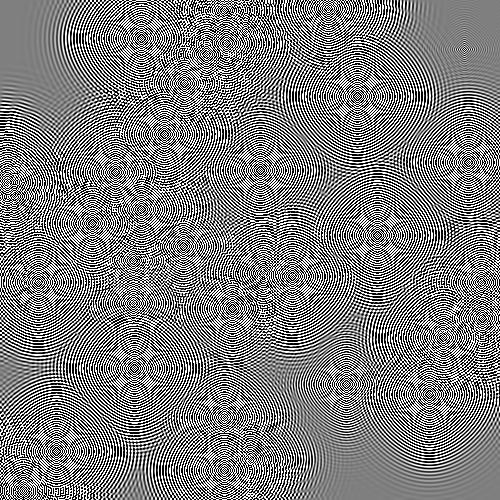

In [7]:
# Grid size 
N = 500

# Initial Conditions -- some rain drops hit a pond

# Set everything to zero
u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

# Some rain drops hit a pond at random points
for n in range(40):
    a, b = np.random.randint(0, N, 2)
    u_init[a, b] = np.random.uniform()


# print(u_init[0])
# exit(0)
DisplayArray(u_init, rng=[-0.1, 0.1])



# Parameters:
# eps -- time resolution
# damping -- wave damping
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(
    U.assign(U_),
    Ut.assign(Ut_))

# Initialize state to initial conditions
tf.global_variables_initializer().run()



# R - run steps of PDE
R = 3000
# wt - waittime flag 
wt=1 
for i in range(R):
    # Step simulation
    step.run({eps: 0.03, damping: 0.04})
    # print(U.eval())
#     print(i)
#     cv2.imshow('KDE', U.eval())
#     if i == R-1:
#         wt = 0
#     cv2.waitKey(wt)

    DisplayArray(U.eval(), rng=[-0.1, 0.1])
